
<img src="https://www.unad.edu.co/images/footer/logo-unad-acreditacion-min.png" width="780" height="140" align="right"/>

<p align="center">Curso: Proyecto Grado</p>

<p align="center"> Código Curso: </p>

<p align="center"> Grupo:  </p>

 <p align="center">   </p>

 <p align="center">  Presentado por: Juan José García Sánchez </p>

<p align="center"> Código: 203008077</p>

 <p align="center"> Tutor(a): Dayana Alejandra Barrera</p>

 <p align="center"> 09/04/2025 </p>

 <p align="center"> UNIVERSIDAD NACIONAL ABIERTA Y A DISTANCIA - UNAD </p>



# Objetivo General

### Aplicar técnicas de análisis de datos sobre un dataset de la calidad del aire,  con el propósito de identificar factores y patrones de contaminación atmosférica, en la ciudad de Bogotá.

# Objetivos Especificos

### 1.	Identificar variables relevantes para el diagnóstico,  en el estudio de la calidad del aire, a partir de la literatura existente, para su análisis en este trabajo.

### 2.	Realizar una limpieza y preprocesamiento de los datos sobre la calidad del aire, para facilitar el análisis y visualización entre características.

### 3.	Analizar la relación entre la concentración de contaminantes, material particulado, y variables meteorológicas; y su papel en la disminución de la calidad del aire, utilizando métodos estadísticos.

# Importar librerias

In [64]:
from enum import StrEnum
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, chisquare, f_oneway
from data_science_tools.stats import medidas_resumen
from data_science_tools.graficos import heatmap
formato = "{:.3f}"
pd.options.display.float_format = formato.format

# Limpieza de datos

Cargar datos a un dataframe, realizar una combinación y eliminar los posibles datos nulos.

In [3]:

r_reporte = Path("datasets/reporte_sisaire.csv")

df_reporte = pd.read_csv(r_reporte)


#limpiado de datos, el archivo csv debe estar en el mismo directorio

df_reporte.drop_duplicates(inplace=True)

#Transformar fechas a datetime objects
df_reporte["Fecha inicial"] = pd.to_datetime(df_reporte["Fecha inicial"], format="%Y-%m-%d")

#limpieza hecha para los tres modelos: modelo lineal, logistico, y knn. se elimina la columna "wip"
#df_reporte = df_crudo.dropna(axis=1)

In [49]:
class At(StrEnum):
    est = 'Estacion' 
    f = 'Fecha inicial' 
    año = "año"
    h10 = 'HAire10' 
    hh = 'HAire?h'
    nox = 'NOx' 
    so2_tr = 'SO2 TR'
    tempcm = 'TMPR AIR 10CM'
    
class Var(StrEnum):
    co = 'CO' 
    dirv = 'DViento' 
    h2 = 'HAire2'  
    no = 'NO' 
    no2 = 'NO2' 
    o3 = 'O3'
    prec = 'PLiquida' 
    pm10 = 'PM10'
    pm2= 'PM2.5'
    rad = 'RGlobal' 
    so2 = 'SO2' 
    temp10 = 'TAire10'
    temp2 = 'TAire2'
    velv = 'VViento' 
    p = 'P'


In [42]:
df_reporte.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81615 entries, 0 to 81614
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Estacion       81615 non-null  object        
 1   Fecha inicial  81615 non-null  datetime64[ns]
 2   CO             50652 non-null  float64       
 3   DViento        47762 non-null  float64       
 4   HAire10        968 non-null    float64       
 5   HAire2         29890 non-null  float64       
 6   HAire?h        719 non-null    float64       
 7   NO             39402 non-null  float64       
 8   NO2            50834 non-null  float64       
 9   NOx            1867 non-null   float64       
 10  O3             58530 non-null  float64       
 11  PLiquida       43655 non-null  float64       
 12  PM10           73891 non-null  float64       
 13  PM2.5          56728 non-null  float64       
 14  RGlobal        26346 non-null  float64       
 15  SO2            2526

## Diccionario de Datos

Diccionario de datos para las mediciones de la red de monitoreo de la calidad del aire (RMCAB) en Bogota, obtenida mediante la pagina de SISAIRE del IDEAM. los campos clave corresponden al de la Estación y la Fecha inicial. 
Los valores de las concentraciones pueden ser menores a cero debido a errores de las estaciones. 

|Campos | Descripción | Clasificación| Niveles |
|---|---|---|---|
| $Estacion$ | Estación (nombre) donde se realizao la medición | categorica (texto) | 24 valores de estación, representado localidad o una fuente de datos. |
| $Fecha\: inicial$ | fecha del dia de la medición | Categorica | texto con formato año-mes-dia, desde el 2010-01-01 al 2025-03-31 |
| $CO$ | Concentración monoxido de carbono | numerica | número real mayor a cero, en $\mu gm^{-3}$ |
| $NO$ | Concentración monoxido de nitrogeno | numerica | número real mayor a cero, en $\mu gm^{-3}$|
| $NO_2$ | Concentración oxido nitroso | numerica | número real mayor a cero, en $\mu gm^{-3}$ |
| $NO_x$ | Concentración combinada de otro compuestos gaseosos de nitrogeno  | numerica | número real positivo, en $mgm^{-3}$ |
| $O_3$ | Concentración de Ozono | numerica | número real mayor a cero, en $\mu gm^{-3}$ |
| $SO_2$ | Concentración de dioxido de azufre | numerica | número real positivo, en $\mu gm^{-3}$ |
| $SO_2 TR$ | Concentración de azufre total reducido: compuesto de azufre gaseosos conteniendo organosulfuro | numerica | número real positivo, en $\mu gm^{-3}$ |
| $PM_{2.5}$ | Concentración del material particulado de diametro $\le 2.5$ micras | numerica | número real positivo, en $\mu gm^{-3}$ |
| $PM_{10}$ | Concentración del material particulado de diametro a $\le 10$ micras | numerica | número real positivo, en $\mu gm^{-3}$ |
| $R_{global}$ | Radiación solar global | numerica | número real positivo, en $Wh m^{-2}$|
| $D_{Viento}$ | Dirección del viento | numerica | número real positivo, en grados|
| $V_{Viento}$ | Velocidad del viento | numerica | número real positivo, en $ms^{-1}$|
| $Haire_{10}$ | Humedad relativa del aire, medida a $10 m$ | numerica | porcentaje de saturación (%)|
| $Haire_{2}$ | Humedad relativa del aire, medida a $2 m$ | numerica | porcentaje de saturación (%)|
| $Haire_{h}$ | Humedad relativa del aire, medida a altura diferentes de 2 o 10 m | numerica | porcentaje de saturación (%)|
| $Taire_{10}$ | Temperatura del aire, medida a $10 m$ | numerica | grados celsius (°C)|
| $Taire_{2}$ | Temperatura del aire, medida a $2 m$ | numerica | grados celsius (°C)|
| $Taire_{10cm}$ | Temperatura del aire, medida a $10 cm$ | numerica | grados celsius (°C)|
| $P$ | Presón atmosferica | numerica | número real positivo, en mmHg|
| $P_{liquida}$ | nivel de precipitación  | numerica | número real positivo, en mm|

In [13]:
df_reporte.describe()

,Fecha inicial,CO,DViento,HAire10,HAire2,HAire?h,NO,NO2,NOx,O3,...,PM10,PM2.5,RGlobal,SO2,SO2 TR,TAire10,TAire2,TMPR AIR 10CM,VViento,P
count,81615,50652.000,47762.000,968.000,29890.000,719.000,39402.000,50834.000,1867.000,58530.000,...,73891.000,56728.000,26346.000,25262.000,20569.000,3712.000,40031.000,2397.000,48016.000,22630.000
mean,2018-07-06 08:12:35.861054976,393.588,177.078,69.467,66.428,64.020,23.320,24.367,45.307,17.792,...,40.716,17.477,162.319,7.424,2.505,14.683,14.935,15.241,1.675,562.565
min,2010-01-01 00:00:00,0.000,0.000,47.000,0.000,31.125,-2.676,0.150,6.327,0.000,...,-9999.000,0.200,0.000,0.000,0.000,11.258,0.000,11.863,0.000,50.500
25%,2014-07-25 12:00:00,0.891,135.834,63.958,60.833,59.396,9.490,14.513,25.292,9.407,...,23.500,9.500,122.167,2.150,1.106,14.058,14.133,14.592,1.163,562.783
50%,2019-03-05 00:00:00,338.441,174.125,69.146,66.167,63.375,17.669,22.118,40.111,14.839,...,36.230,15.528,156.958,3.852,1.775,14.683,14.913,15.225,1.538,563.667
75%,2022-06-07 00:00:00,659.431,217.458,74.875,71.579,69.380,30.059,32.295,57.061,23.491,...,53.097,23.383,197.250,7.264,3.002,15.300,15.729,15.925,2.013,564.375
max,2025-03-31 00:00:00,5025.540,358.042,90.043,121.000,83.000,646.522,126.747,356.840,154.700,...,1103.000,197.357,504.154,117.520,35.456,18.140,24.250,18.462,6.942,567.221
std,NaN,457.688,54.636,7.649,8.605,6.716,21.084,12.778,28.371,11.506,...,47.783,10.354,55.937,11.064,2.301,0.906,1.233,1.000,0.748,18.849


In [5]:
fecha_max = pd.to_datetime("2025-03-31",  format="%Y-%m-%d")
fecha_antes5 = fecha_max - pd.DateOffset(years=5)
fecha_antes10 = fecha_max - pd.DateOffset(years=10)
fecha_antes15 = fecha_max - pd.DateOffset(years=15)

df_rep5 = df_reporte[df_reporte[At.f] >= fecha_antes5]
df_rep10 = df_reporte[df_reporte[At.f] >= fecha_antes10]
df_rep15 = df_reporte[df_reporte[At.f] >= fecha_antes15]


In [6]:
def obtener_prop_validos(df, año):
    conteo_no_nulos = df.notna().sum()

    conteo_fracc = conteo_no_nulos[2:]/conteo_no_nulos[At.est] * 100

    conteo_fracc = pd.concat([conteo_fracc], axis=1)

    conteo_fracc.reset_index(inplace=True)

    conteo_fracc.rename(columns = {0:"porcentaje", "index":"variable"}, inplace=True)

    conteo_fracc["año"] = año
    
    return conteo_fracc


df_por_intervalo = (df_rep5, df_rep10, df_rep15)
años = (5, 10, 15)

array_conteo = [obtener_prop_validos(df, año) for df, año in zip(df_por_intervalo, años)]

conteo_fracc = pd.concat(array_conteo)


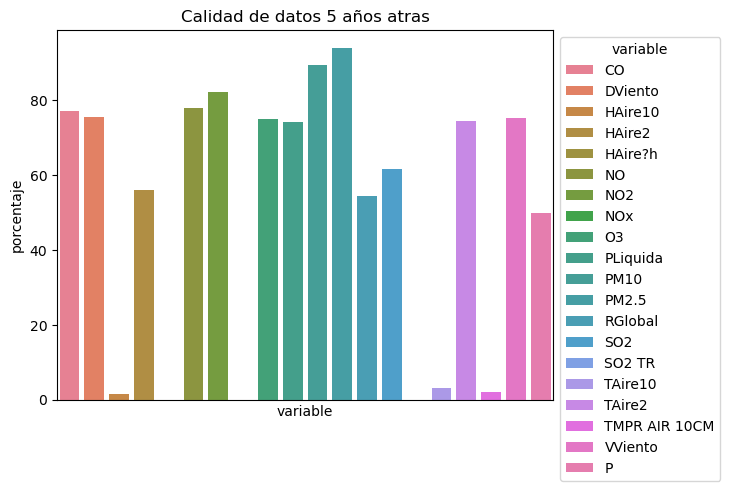

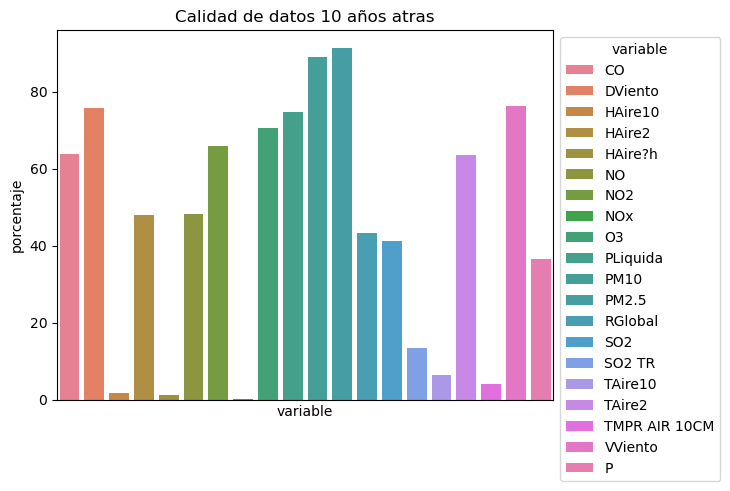

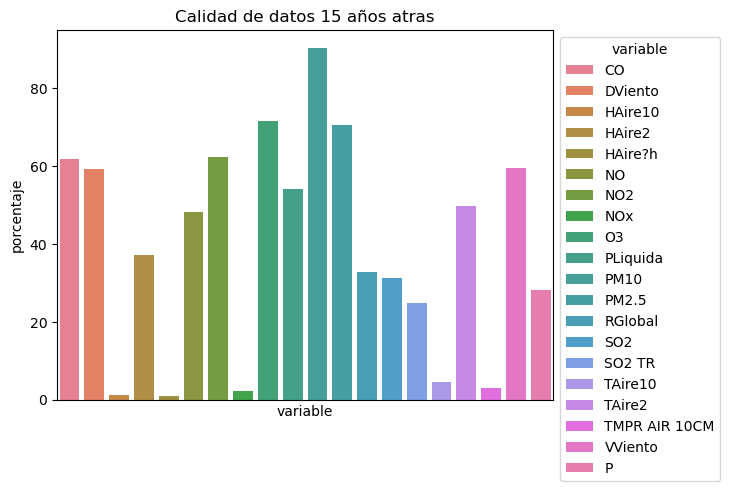

In [7]:
for df, año in zip(array_conteo, años):
    eje = sns.barplot(data=df, x="variable", y="porcentaje", hue="variable", legend="full")
    eje.set(xticks=[])
    eje.set_title(f"Calidad de datos {año} años atras")
    sns.move_legend(eje, "upper left", bbox_to_anchor=(1, 1))
    plt.show()

    #eje.get_figure().savefig(f'comp {año}.png')
    

C:\Users\frajg\miniconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


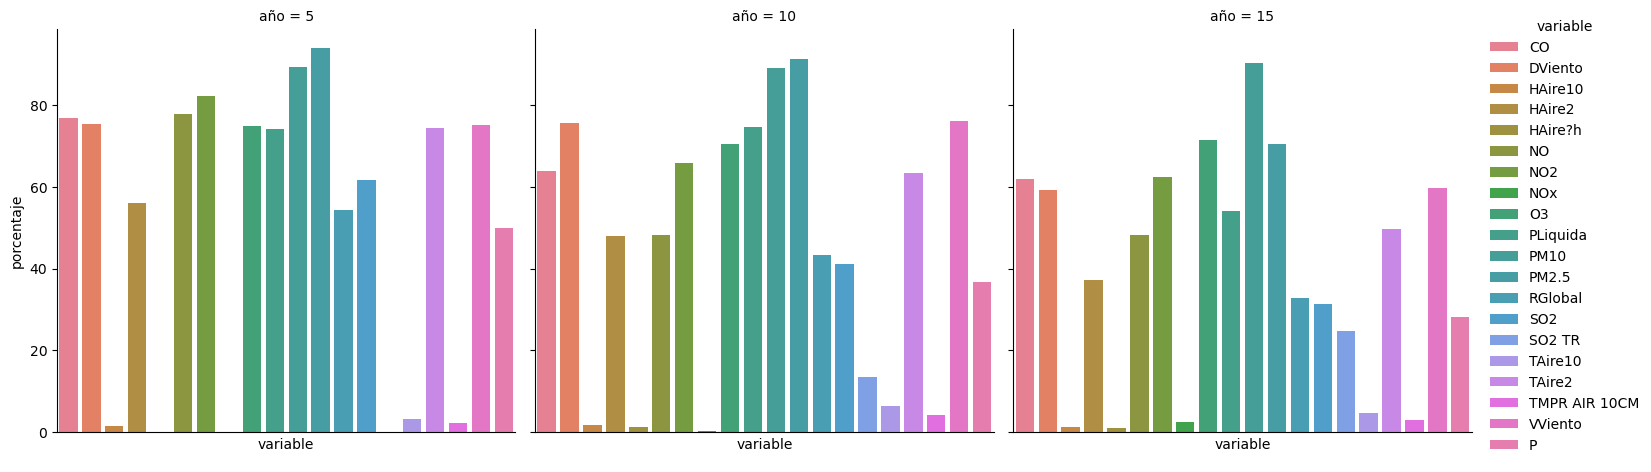

In [9]:
ejes_comp_años = sns.catplot(data=conteo_fracc, x="variable", y="porcentaje", col="año", kind="bar", hue="variable", legend="full")
ejes_comp_años.set(xticks=[])
plt.show()


# Version Final de los datos a 5 años

 el dataframe datos contiene los datos sin index por años, el dataframe datos_año contiene indices  por años para poder acceder a los datos como si fueran agrupados por años

In [27]:
df_rep5[At.año] =  df_rep5[At.f].apply(lambda x: x.year)
datos = df_rep5.drop([At.h10, At.hh, At.nox, At.so2_tr, At.tempcm], axis=1)
datos_año = datos.set_index([At.año])

C:\Users\frajg\AppData\Local\Temp\ipykernel_13256\2334945463.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rep5[At.año] =  df_rep5[At.f].apply(lambda x: x.year)


# 1. Analisis Unidimensional

In [14]:
datos.index.unique()

Index([2020, 2021, 2022, 2023, 2024, 2025], dtype='int64', name='año')

## Medidas de Resumen del dataset años 2020 - 2025

In [52]:
resum = [medidas_resumen(datos_año.loc[2020], col) for col in Var]
resumen = pd.concat(resum, axis=1)
resumen

,CO,DViento,HAire2,NO,NO2,O3,PLiquida,PM10,PM2.5,RGlobal,SO2,TAire10,TAire2,VViento,P
count,2701.000,3640.000,2284.000,2847.000,3105.000,3421.000,2978.000,3758.000,4213.000,1651.000,2814.000,1104.000,1732.000,3636.000,1180.000
mean,764.670,172.464,66.974,23.302,28.094,25.327,0.124,29.780,14.666,175.980,7.753,14.708,14.826,1.748,563.297
std,433.738,52.850,8.319,20.709,12.578,11.155,0.279,18.468,8.832,52.561,11.635,0.869,1.007,0.907,2.040
min,0.254,23.125,38.500,0.123,1.628,0.883,0.000,2.565,0.588,55.294,0.214,11.592,11.492,0.250,555.417
25%,457.960,132.490,61.250,8.969,18.686,17.192,0.000,16.634,7.729,137.000,2.092,14.094,14.133,1.175,563.131
50%,667.858,168.479,66.229,17.105,26.503,23.953,0.008,25.879,12.958,169.000,3.562,14.698,14.773,1.554,563.833
75%,967.961,210.510,71.344,29.508,35.978,31.457,0.104,38.247,19.750,207.729,7.103,15.285,15.488,2.013,564.375
max,2941.895,321.792,95.783,133.040,78.481,84.410,3.242,172.368,65.458,362.625,76.916,17.275,18.167,5.996,565.917
var,188128.403,2793.138,69.208,428.847,158.218,124.429,0.078,341.077,78.012,2762.652,135.368,0.756,1.014,0.822,4.163


In [53]:
resum = [medidas_resumen(datos_año.loc[2021], col) for col in Var]
resumen = pd.concat(resum, axis=1)
resumen

,CO,DViento,HAire2,NO,NO2,O3,PLiquida,PM10,PM2.5,RGlobal,SO2,TAire10,TAire2,VViento,P
count,5965.000,6373.000,4619.000,6428.000,6635.000,5907.000,4216.000,6625.000,7008.000,3696.000,4652.000,0.000,5907.000,6326.000,3375.000
mean,781.895,190.566,69.316,24.515,28.376,23.063,0.141,31.522,15.847,161.959,6.661,NaN,14.792,1.709,562.868
std,497.596,51.845,9.578,25.413,13.839,9.901,0.306,17.347,9.346,52.058,7.446,NaN,1.255,0.840,2.238
min,0.000,0.000,0.000,0.276,2.479,0.352,0.000,2.112,0.791,0.000,0.058,NaN,0.000,0.000,554.708
25%,462.730,152.375,63.312,9.095,17.724,15.798,0.000,18.717,8.699,124.083,2.411,NaN,14.121,1.163,562.292
50%,647.117,190.826,69.042,16.766,26.898,22.100,0.008,28.625,14.500,157.833,4.167,NaN,14.808,1.517,563.375
75%,938.545,230.750,74.958,29.053,37.061,29.067,0.134,40.450,20.997,194.042,7.785,NaN,15.521,2.008,564.250
max,4298.145,332.333,98.958,288.814,126.747,70.020,3.708,127.042,81.125,354.500,69.633,NaN,20.156,6.942,566.875
var,247601.443,2687.864,91.732,645.843,191.525,98.037,0.094,300.913,87.351,2710.067,55.437,NaN,1.574,0.705,5.006


In [54]:
resum = [medidas_resumen(datos_año.loc[2022], col) for col in Var]
resumen = pd.concat(resum, axis=1)
resumen

,CO,DViento,HAire2,NO,NO2,O3,PLiquida,PM10,PM2.5,RGlobal,SO2,TAire10,TAire2,VViento,P
count,6232.000,5821.000,4700.000,6215.000,6562.000,5722.000,5019.000,6215.000,6747.000,4317.000,4637.000,0.000,5964.000,5700.000,4000.000
mean,775.458,192.513,68.960,24.588,29.541,22.077,0.150,34.049,17.374,153.261,5.722,NaN,14.689,1.546,562.762
std,435.986,53.854,8.218,22.353,12.339,11.378,0.301,16.810,8.523,51.061,5.555,NaN,1.019,0.723,2.068
min,57.301,18.750,34.622,0.692,2.945,0.096,0.000,2.994,1.846,0.000,0.145,NaN,8.850,0.000,555.625
25%,498.353,151.750,63.693,10.423,19.996,13.618,0.000,22.044,11.258,116.333,2.269,NaN,13.988,1.058,562.208
50%,677.681,193.750,68.958,18.280,28.620,20.616,0.017,31.126,16.333,147.833,4.029,NaN,14.675,1.413,563.250
75%,940.197,233.500,74.333,31.318,38.086,28.995,0.162,42.700,22.333,185.583,6.899,NaN,15.404,1.829,564.042
max,5025.540,335.000,97.708,218.262,123.090,80.426,2.779,140.000,82.083,323.478,58.943,NaN,23.200,5.579,566.583
var,190084.165,2900.306,67.543,499.667,152.245,129.458,0.091,282.577,72.646,2607.184,30.856,NaN,1.038,0.523,4.276


In [55]:
resum = [medidas_resumen(datos_año.loc[2023], col) for col in Var]
resumen = pd.concat(resum, axis=1)
resumen

,CO,DViento,HAire2,NO,NO2,O3,PLiquida,PM10,PM2.5,RGlobal,SO2,TAire10,TAire2,VViento,P
count,6036.000,5297.000,3973.000,5762.000,6055.000,5167.000,6492.000,6770.000,6898.000,4335.000,4681.000,0.000,5797.000,5336.000,4001.000
mean,632.106,177.123,65.888,18.292,28.353,23.601,0.102,31.156,15.523,150.017,5.427,NaN,15.326,1.653,563.037
std,275.348,54.173,8.022,13.736,12.787,11.630,0.248,17.874,9.124,48.326,6.818,NaN,1.123,0.611,2.055
min,28.622,16.609,34.878,0.317,0.940,0.000,0.000,3.013,1.887,0.000,0.155,NaN,8.900,0.263,555.708
25%,429.337,134.042,60.286,8.046,18.130,14.964,0.000,17.875,8.530,115.500,2.132,NaN,14.575,1.204,562.500
50%,577.220,174.042,65.667,14.711,26.749,21.613,0.004,27.461,13.870,145.292,3.622,NaN,15.350,1.583,563.500
75%,790.591,217.542,70.667,25.050,37.533,29.912,0.071,40.596,20.708,181.083,6.186,NaN,16.133,2.008,564.292
max,2003.575,330.667,97.167,106.635,87.404,94.488,2.750,123.864,72.130,346.467,117.520,NaN,18.800,4.300,566.667
var,75816.260,2934.675,64.345,188.682,163.508,135.262,0.061,319.467,83.242,2335.415,46.480,NaN,1.261,0.373,4.222


In [56]:
resum = [medidas_resumen(datos_año.loc[2024], col) for col in Var]
resumen = pd.concat(resum, axis=1)
resumen

,CO,DViento,HAire2,NO,NO2,O3,PLiquida,PM10,PM2.5,RGlobal,SO2,TAire10,TAire2,VViento,P
count,5719.000,4737.000,3579.000,5733.000,6077.000,5768.000,6375.000,7207.000,7297.000,4443.000,4505.000,0.000,5928.000,4738.000,4238.000
mean,602.364,185.848,65.722,17.752,29.676,25.688,0.105,34.382,17.199,164.942,4.990,NaN,15.616,1.530,559.718
std,248.258,54.346,10.139,13.566,13.160,13.240,0.257,19.763,11.139,56.593,4.981,NaN,1.236,0.540,43.262
min,23.852,31.125,14.129,0.792,2.459,1.030,0.000,2.722,0.704,0.000,0.175,NaN,9.944,0.200,50.500
25%,424.156,142.625,60.000,7.804,19.360,15.794,0.000,19.213,8.455,123.396,2.444,NaN,14.792,1.146,562.958
50%,562.909,183.917,65.917,14.130,28.528,23.495,0.000,30.308,14.818,160.542,3.775,NaN,15.621,1.450,563.958
75%,741.459,227.583,72.083,24.244,38.313,33.618,0.067,45.660,23.917,203.458,6.023,NaN,16.462,1.812,564.625
max,1765.054,324.292,93.786,126.156,119.358,114.369,3.400,139.167,92.667,395.000,102.551,NaN,24.250,3.961,566.958
var,61632.243,2953.445,102.795,184.034,173.182,175.288,0.066,390.565,124.069,3202.738,24.815,NaN,1.527,0.292,1871.641


In [57]:
resum = [medidas_resumen(datos_año.loc[2025], col) for col in Var]
resumen = pd.concat(resum, axis=1)
resumen

,CO,DViento,HAire2,NO,NO2,O3,PLiquida,PM10,PM2.5,RGlobal,SO2,TAire10,TAire2,VViento,P
count,459.000,728.000,581.000,452.000,542.000,435.000,1040.000,912.000,954.000,708.000,420.000,0.000,876.000,727.000,758.000
mean,647.066,200.375,67.618,16.959,33.466,26.288,0.085,34.936,19.399,163.359,9.831,NaN,15.076,1.410,563.000
std,262.858,54.452,8.934,10.485,12.030,10.251,0.222,16.348,10.957,56.698,15.894,NaN,1.081,0.456,1.957
min,130.846,35.333,32.042,1.626,7.812,4.970,0.000,5.427,2.154,13.000,1.077,NaN,11.287,0.371,556.000
25%,450.566,159.031,62.333,8.821,24.641,18.749,0.000,23.925,12.812,119.854,2.301,NaN,14.324,1.092,562.458
50%,599.828,205.833,67.917,14.910,33.583,24.778,0.000,31.642,16.833,156.750,3.213,NaN,15.079,1.383,563.521
75%,816.361,244.625,73.417,23.298,41.645,33.526,0.042,42.591,22.791,201.292,5.982,NaN,15.889,1.679,564.167
max,1835.656,302.583,89.750,72.522,73.069,55.803,2.208,104.200,79.045,329.125,63.819,NaN,17.600,3.550,565.500
var,69094.584,2965.002,79.810,109.944,144.715,105.082,0.049,267.252,120.048,3214.692,252.622,NaN,1.169,0.208,3.831


##### Visualización

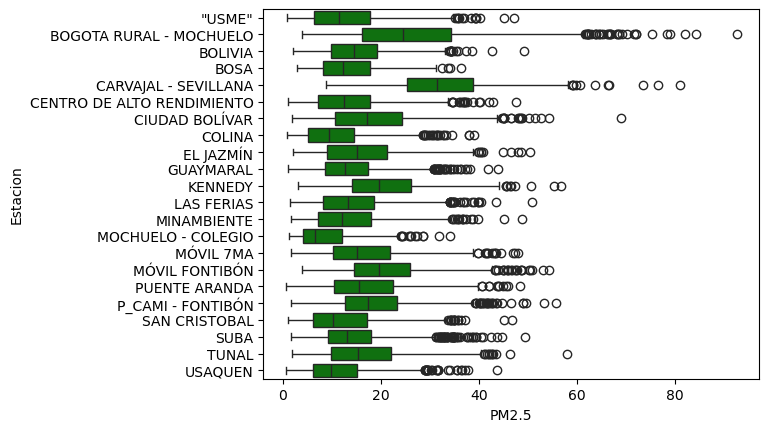

In [28]:
sns.boxplot(data=datos, x=At.pm2, y=At.est,  orient="h", color="g")
plt.show()

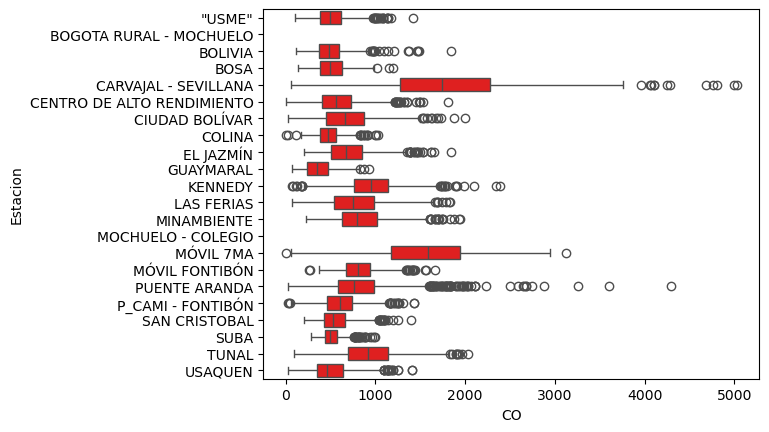

In [30]:
sns.boxplot(data=datos, x=At.co, y=At.est,  orient="h", color="r")
plt.show()

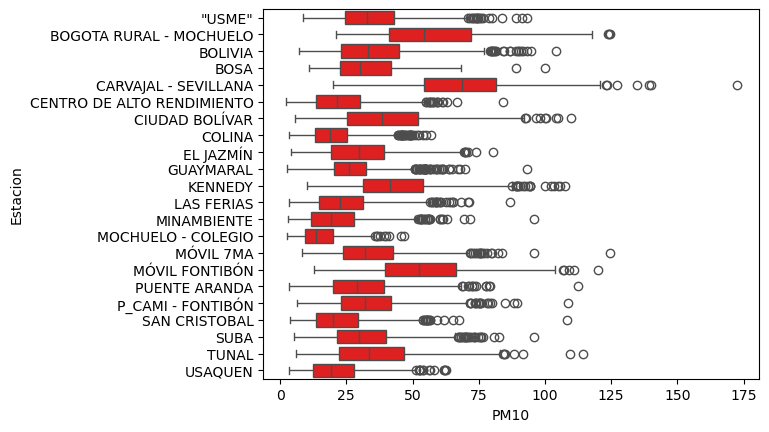

In [31]:
sns.boxplot(data=datos, x=At.pm10, y=At.est,  orient="h", color="r")
plt.show()

##### Analisis:

In [26]:
datos[datos.duplicated()]

,Estacion,Fecha inicial,CO,DViento,HAire2,NO,NO2,O3,PLiquida,PM10,PM2.5,RGlobal,SO2,TAire10,TAire2,VViento,P
año,,,,,,,,,,,,,,,,,


# 2. Análisis Bidimensional e Inferencial.

## 1. Dispersion de pares

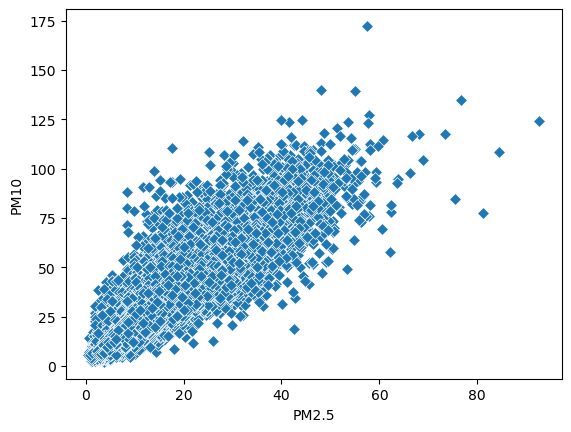

In [62]:
sns.scatterplot(datos, x=Var.pm2, y=Var.pm10, marker="D")
plt.show()

### Costo Historico del Viaje vs. Puntaje Promedio 

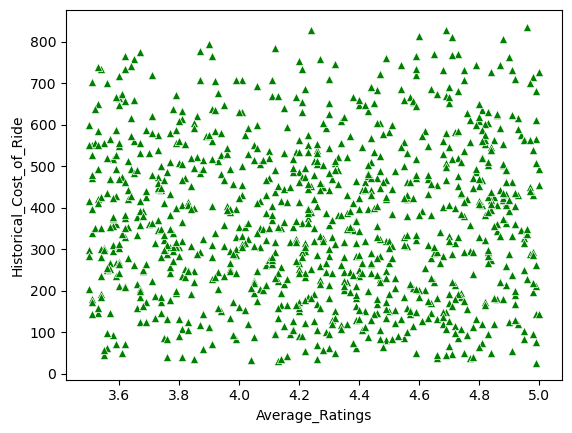

In [172]:
sns.scatterplot(df_modelos, x=Num.puntaje_promedio.value, y=Num.costo_historico.value, color="g", marker="^" )
plt.show()

### Costo Historico del Viaje vs. Duracion Esperada del Viaje 

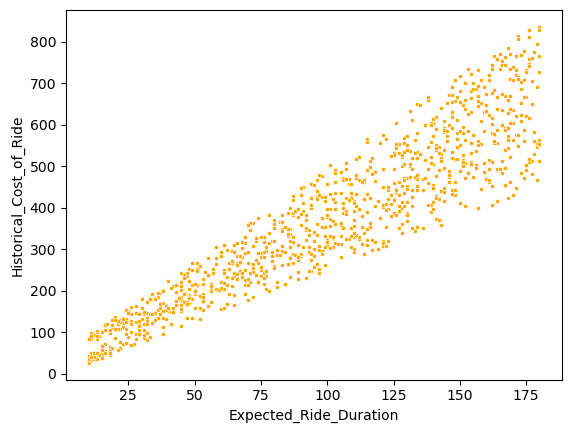

In [175]:
sns.scatterplot(df_modelos, x=Num.duracion_esperada.value, y=Num.costo_historico.value , color="orange", marker=".")
plt.show()

### Analisis de tendencias

## 2. Correlaciones Lineales

El siguiente fragmento de codigo calcula los coeficientes de correlación de pearson, y los valores *P* de la prueba de correlación asociada al mismo tiempoo.
Se hacen pares de las variables numericas en estudio secuencialmente, y toda la informacion se consigna en dos DataFrames: uno llamado  `corr` que contiene
los coeficientes, y otro llamado `valores_p` que contiene los valores p de las pruebas estadisticas.

In [77]:
variables = datos[[Var.co, Var.pm2, Var.pm10, Var.no, Var.no2, Var.o3]].dropna()


corr = pd.DataFrame(index=variables.columns, columns=variables.columns)

valores_p = corr.copy()

for variable_1 in variables.columns:
    coefs = []
    p_valores = []
 
    for variable_2 in variables.columns:
        coef, p_valor = pearsonr(variables[variable_1], variables[variable_2])
        coefs.append(coef)
        p_valores.append(p_valor)

    corr[variable_1] = coefs
    valores_p[variable_1] = p_valores

In [72]:
datos[[var for var in Var]]

,CO,DViento,HAire2,NO,NO2,O3,PLiquida,PM10,PM2.5,RGlobal,SO2,TAire10,TAire2,VViento,P
0,395.945,199.458,64.667,12.628,23.803,33.730,NaN,25.804,7.680,168.250,13.639,NaN,14.654,1.312,561.292
1,413.160,198.500,64.000,27.557,31.497,23.134,NaN,32.312,12.557,246.583,8.528,NaN,14.575,1.550,560.917
2,486.582,207.042,68.625,12.526,25.299,30.812,NaN,27.337,14.183,190.542,10.529,NaN,14.454,1.538,561.083
3,343.470,208.208,73.083,7.814,20.943,33.951,NaN,10.058,7.638,155.542,6.994,NaN,14.537,1.504,562.000
4,290.995,204.083,67.333,12.245,25.213,38.872,NaN,24.467,11.629,221.208,8.030,NaN,14.729,1.600,562.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81610,NaN,152.417,NaN,NaN,NaN,NaN,0.000,21.712,11.750,NaN,NaN,NaN,15.058,1.604,NaN
81611,NaN,169.042,NaN,NaN,NaN,NaN,0.000,28.587,12.542,NaN,NaN,NaN,14.688,1.333,NaN
81612,NaN,151.292,NaN,NaN,NaN,NaN,0.000,28.583,11.042,NaN,NaN,NaN,15.567,1.421,NaN
81613,NaN,146.417,NaN,NaN,NaN,NaN,0.004,29.204,13.667,NaN,NaN,NaN,15.150,1.087,NaN


In [76]:
datos[[Var.co, Var.pm2, Var.pm10, Var.no, Var.no2, Var.o3]].dropna()

,CO,PM2.5,PM10,NO,NO2,O3
0,395.945,7.680,25.804,12.628,23.803,33.730
1,413.160,12.557,32.312,27.557,31.497,23.134
2,486.582,14.183,27.337,12.526,25.299,30.812
3,343.470,7.638,10.058,7.814,20.943,33.951
4,290.995,11.629,24.467,12.245,25.213,38.872
...,...,...,...,...,...,...
81537,768.228,19.273,54.061,17.323,37.142,29.027
81538,718.425,17.375,35.312,10.747,34.051,45.469
81539,628.741,17.708,35.870,11.544,24.719,38.913
81540,333.452,11.130,19.970,3.593,12.356,48.633


### Coeficientes de Correlación

<Axes: title={'center': 'Coeficientes Pearson'}>

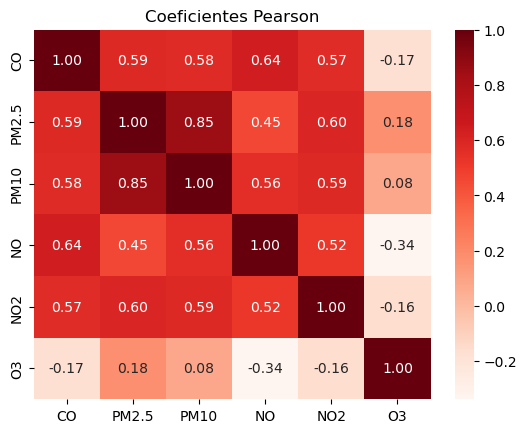

In [78]:
heatmap(corr, "Coeficientes Pearson")

### Valores P de las pruebas estadiscas de correlación

<Axes: title={'center': 'Valores P'}>

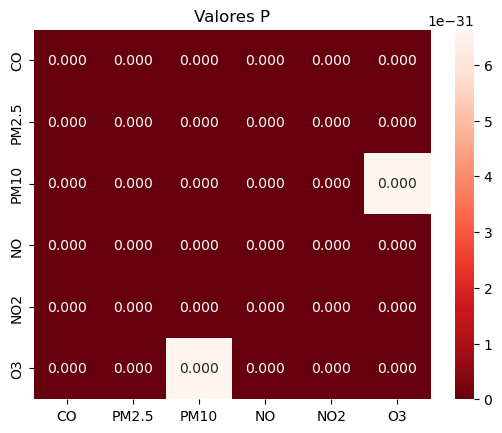

In [79]:
heatmap(valores_p, "Valores P", formato=".3f", mapa="Reds_r")

### Analisis Sobre las correlaciones:

## 3. Pruebas ANOVA

In [107]:
def mostrar_anova(resultados):
    """
    mostrar un pequeño resumen de los
    resultados de un prueba ANOVA
    """

    print(f"Valor F: {resultados.statistic:.3f}")
    
    print(f"Valor P: {resultados.pvalue:.3f}")
    
 
grupos_lealtad = df_modelos.groupby([Categ.lealtad.value])

### Puntaje Promedio vs. Lealtad del Cliente

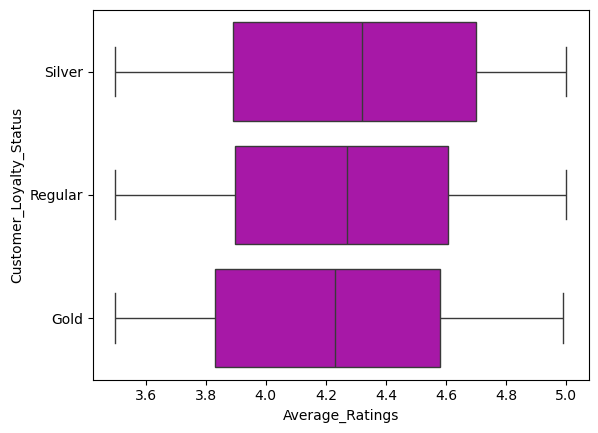

In [225]:
sns.boxplot(data=df_modelos, x=Num.puntaje_promedio.value, y=Categ.lealtad.value, color="m")
plt.show()

In [108]:
muestras_puntaje = grupos_lealtad[Num.puntaje_promedio.value].apply(np.array)
display(muestras_puntaje)
resultados = f_oneway(*muestras_puntaje) 
mostrar_anova(resultados)

Customer_Loyalty_Status
Gold       [3.59, 4.14, 4.12, 4.31, 3.81, 4.39, 4.79, 4.6...
Regular    [4.31, 3.77, 4.41, 4.69, 4.95, 4.95, 3.97, 3.6...
Silver     [4.47, 4.06, 3.99, 3.51, 3.74, 3.85, 4.22, 4.5...
Name: Average_Ratings, dtype: object

Valor F: 2.314
Valor P: 0.099


#### Interpretación Caja de bigotes:

#### ANOVA

### Numero de Pasajeros vs. Lealtad del Cliente

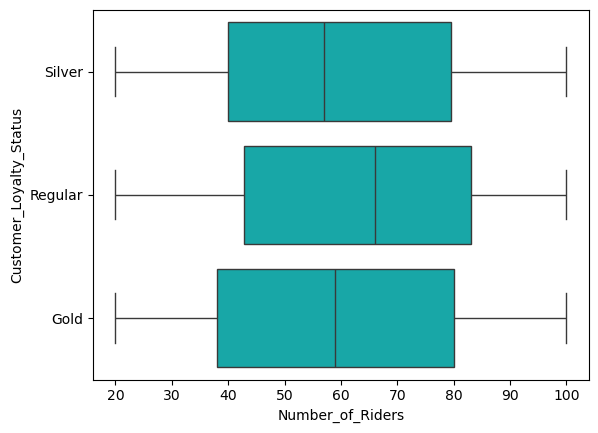

In [223]:
sns.boxplot(data=df_modelos, x=Num.pasajeros.value, y=Categ.lealtad.value, color="c")
plt.show()

In [109]:
muestras_pasajeros = grupos_lealtad[Num.pasajeros.value].apply(np.array)
display(muestras_pasajeros)
resultados = f_oneway(*muestras_pasajeros) 
mostrar_anova(resultados)

Customer_Loyalty_Status
Gold       [62, 60, 24, 33, 48, 72, 75, 39, 35, 28, 25, 6...
Regular    [89, 78, 93, 86, 63, 96, 74, 24, 56, 62, 68, 2...
Silver     [90, 58, 42, 59, 79, 42, 36, 39, 38, 46, 31, 2...
Name: Number_of_Riders, dtype: object

Valor F: 2.384
Valor P: 0.093


### Duración del Viaje vs. Lealtad del Cliente

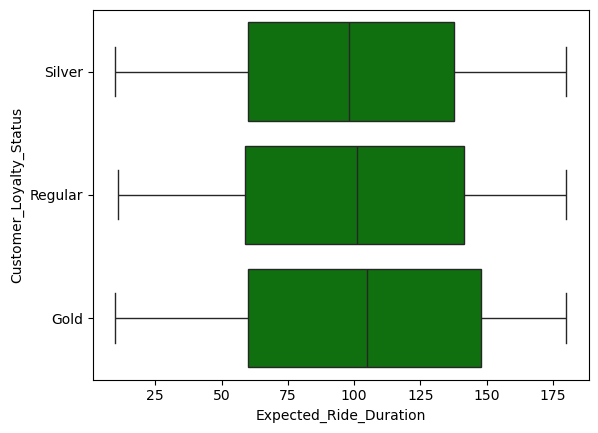

In [228]:
sns.boxplot(data=df_modelos, x=Num.duracion_esperada.value, y=Categ.lealtad.value, color="g")
plt.show()

# Referencias

- Kane, F. (2017). Hands-On Data Science and Python Machine Learning. Packt
Publishing.

- Rubio, M. (2019). Estadística con aplicaciones en R. Utadeo.

- Samuels, M., Witmer, J., & Shaffner, A. (2012). Fundamentos de Estadística Para Las Ciencias de la Vida (4th ed.). Pearson.

